# JijZept デモンストレーション

このnotebookでは、実際にJijZeptを用いて組合せ最適化問題を解いてみます。
扱う題材として、「**巡回セールスマン問題**」「**ナップザック問題**」を扱います。

本チュートリアルを進めるにあたり、**自身のマシンにPython環境を構築する必要はありません**。

現在開いているjupyterの環境に全て用意されています。

## 巡回セールスマン問題

複数の都市をなるべく最短経路で巡るにはどうすればよいか？

![](https://raw.githubusercontent.com/Jij-Inc/JijHandsOnMaterials/handson-environment/ja/images/tsp1.png)
![](https://raw.githubusercontent.com/Jij-Inc/JijHandsOnMaterials/handson-environment/ja/images/tsp2.png)

### 定式化

$$
\begin{aligned}
\min_x & \sum_{i,j}d_{i,j}x_{i,t} x_{j,(t+1)\mod n}\\
\mathrm{s.t.} &\sum_t x_{i,t}=1, \forall i\\
&\sum_i x_{i,t} = 1,~\forall t\\
&x_{i,t} \in \{0, 1\}
\end{aligned}
$$

### インスタンスの作成

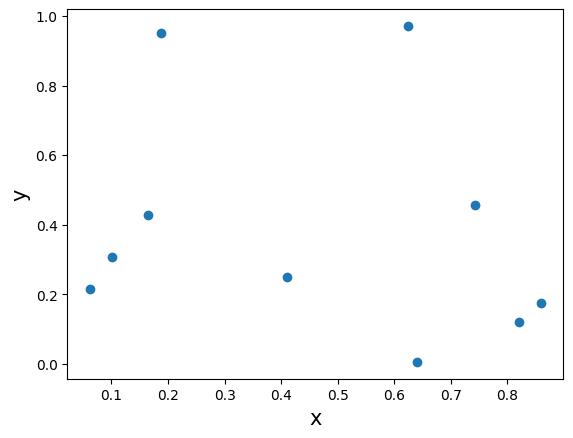

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# ランダムに都市を配置して距離行列を計算
def tsp_distance(n: int):
    x = np.random.uniform(0, 1, n)
    y = np.random.uniform(0, 1, n)
    XX, YY = np.meshgrid(x, y)
    distance = np.sqrt((XX - XX.T)**2 + (YY - YY.T)**2)
    return distance, (x, y)

# n-都市 平面TSP
n = 10

distance, (x_pos, y_pos) = tsp_distance(n=n)

plt.plot(x_pos, y_pos, 'o')
plt.xlabel("x", fontsize=15)
plt.ylabel("y", fontsize=15)
plt.show()

### JijModelingによる実装

In [15]:
import jijmodeling as jm

n = jm.Placeholder("n")
d = jm.Placeholder("d", shape=(n, n))

x = jm.Binary("x", shape=(n, n))

i = jm.Element("i", (0, n))
j = jm.Element("j", (0, n))
t = jm.Element("t", (0, n))

# problem object の作成
problem = jm.Problem("tsp")

# 目的関数の追加
problem += jm.Sum([i, j, t], d[i, j]*x[i, t]*x[j, (t+1) % n])
# 等価な書き方
# problem += jm.Sum(i, jm.Sum(j, jm.Sum(t, d[i, j]*x[i, t]*x[j, (t+1) % n])))

# 2つの制約条件の追加
problem += jm.Constraint("one-city", jm.Sum(t, x[i, t]) == 1, forall=i)
problem += jm.Constraint("one-time", jm.Sum(i, x[i, t]) == 1, forall=t)
problem

In [16]:
instance_data = {
    "d": distance,
    "n": len(distance)
}

In [19]:
import jijzept as jz
import jijmodeling as jm
import os

sampler = jz.JijSASampler(config=os.environ["JIJZEPT_CONFIG_PATH"])
result = sampler.sample_model(problem, instance_data, search=True, num_sweeps=10000, num_search=50)

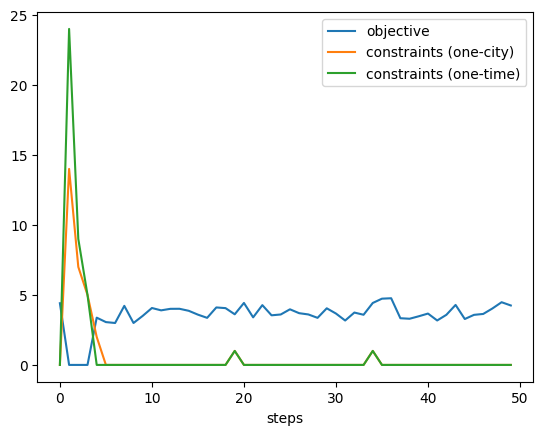

In [34]:
# パラメータサーチにより得られた解の目的関数と制約条件の破れ一覧を表示
objective = np.array(result.evaluation.objective)
onecity_violation = np.array(result.evaluation.constraint_violations["one-city"])
onetime_violation = np.array(result.evaluation.constraint_violations["one-time"])

plt.plot(list(range(0, len(objective))), objectives, label='objective')
plt.plot(list(range(0, len(onecity_violation))), [elem for elem in onecity_violation], label='constraints (one-city)')
plt.plot(list(range(0, len(onetime_violation))), [elem for elem in onetime_violation], label='constraints (one-time)')
plt.xlabel("steps")
plt.legend()
plt.show()

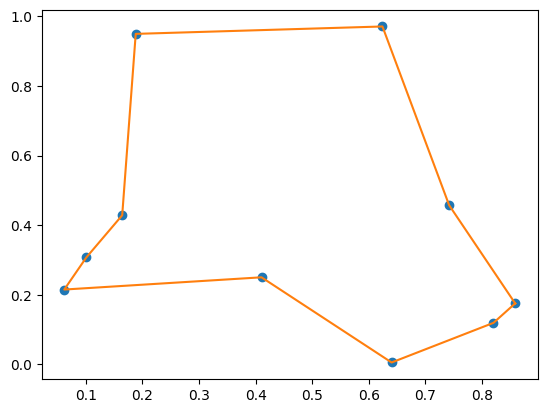

In [35]:
import numpy as np

import numpy as np

# Get feasible solution index
feasible = [i for i, violation in enumerate(onecity_violation + onetime_violation) if violation == 0]

# Get feasible objective
feas_obj = {i: obj_value for i, obj_value in zip(feasible, objective[feasible])}

lowest_index = min(feas_obj, key=feas_obj.get)

nonzero_indices, nonzero_values, shape = result.record.solution["x"][lowest_index]

N_value = len(x_pos)
tour = np.zeros(N_value, dtype=int)

i_value, t_value = nonzero_indices
tour[t_value] = i_value

tour = np.append(tour, [tour[0]])

plt.plot(x_pos, y_pos, "o")
plt.plot(x_pos[tour], y_pos[tour], "-")
plt.show()

## ナップザック問題 (不等式の制約条件)

容量の制約を守ったまま、なるべく優先度が高い荷物を多く詰めるにはどうすればよいか？

![](https://raw.githubusercontent.com/Jij-Inc/JijHandsOnMaterials/handson-environment/ja/images/knapsack.png)

### 定式化

In [36]:
w = jm.Placeholder("weights", dim=1)
v = jm.Placeholder("values", dim=1)
n = jm.Placeholder("num_items").set_latex("n")
c = jm.Placeholder("capacity")
x = jm.Binary("x", shape=(n, ))
# i: itemの添字
i = jm.Element("i", n)

problem = jm.Problem("knapsack")

# objective function
obj = jm.Sum(i, v[i] * x[i])
problem += -1 * obj

# Constraint: knapsack 制約
const = jm.Constraint("knapsack_constraint", jm.Sum(i, w[i] * x[i])  <= c)
problem += const
problem

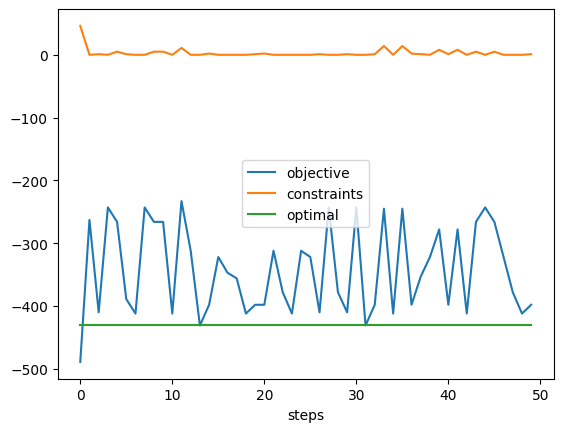

In [38]:
instance_data = {
    "weights": [55.0, 10.0, 47.0, 5.0, 4.0, 50.0, 8.0, 61.0, 85.0, 87.0],
    "values": [95.0, 4.0, 60.0, 32.0, 23.0, 72.0, 80.0, 62.0, 65.0, 46.0],
    "num_items": 10,
    "capacity": 269}

import jijzept as jz
import jijmodeling as jm
import os
sampler = jz.JijSASampler(config=os.environ["JIJZEPT_CONFIG_PATH"])
result = sampler.sample_model(problem, instance_data, search=True, num_search=50)

objective = np.array(result.evaluation.objective)
knapsack_violation = np.array(result.evaluation.constraint_violations["knapsack_constraint"])

# パラメータサーチにより得られた解の目的関数と制約条件の破れ一覧を表示
plt.plot(list(range(0, len(objective))), objective, label='objective')
plt.plot(list(range(0, len(knapsack_violation))), [elem for elem in knapsack_violation], label='constraints')
plt.plot(list(range(0, len(knapsack_violation))), [-431]*len(knapsack_violation), label='optimal')

plt.xlabel("steps")
plt.legend()
plt.show()